In [2]:
#Adams Bashford - Crank Nicholson Burgers Solver
#This solver cranks out the nicholson

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from scipy.linalg import solve_banded
import time

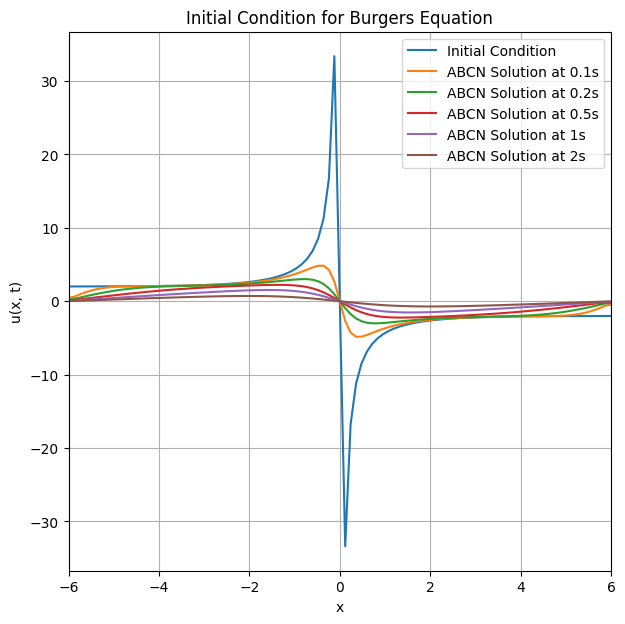

Elapsed time (imports -> pre-plot): 0.134 s


In [3]:

tStart = time.perf_counter()

def generateMeshGrid(x0,xN,dx):
    x = np.arange(x0,xN,dx)
    numPoints = len(x)
    x = np.linspace(x0,xN,numPoints)
    return x,numPoints

def generatePointGrid(x0,xN,numPoints):
    x = np.linspace(x0,xN,numPoints)
    dx = (xN - x0)/(numPoints - 1)
    return x,dx

def applyInitialConditions(x, t):
    u = (-2 * np.sinh(x)) / (np.cosh(x) - np.exp(-t))
    return u

def applyBoundaryConditions(u):
    u[0] = (4 * u[1] - u[2]) / 3.0
    u[-1] = (4 * u[-2] - u[-3]) / 3.0
    return u

def calculateTimeStep(C,dx,u):
    uMax = np.max(np.abs(u))
    dt = C * dx / uMax
    return dt

def firstTimeStep(u0, dt, dx):
    uNext = np.copy(u0)
    alpha = dt / (2 * dx**2)
    beta = dt /(2 * dx)

    N = len(u) - 2
    middleDiagonal = (1 + (2 * alpha)) * np.ones(N)
    sideDiagonals = -alpha * np.ones(N - 1)
    tridiagonalMatrix = np.vstack([np.append(0, sideDiagonals), middleDiagonal, np.append(sideDiagonals, 0)])

    convectiveTerm = -beta * (u[1:-1] * (u[2:] - u[:-2]))
    diffusiveTerm = alpha * (u[2:] + u[:-2]  - 2 * u[1:-1])
    completeRHSterm = u[1:-1] + convectiveTerm + diffusiveTerm

    uNext[1:-1] = solve_banded((1, 1), tridiagonalMatrix, completeRHSterm)
    applyBoundaryConditions(uNext)

    return uNext

def solverAdamBashfordCrankNicholson(u0, u1, dt, tEnd, tBegin):
    uInitial = np.copy(u0)
    uStepOne = np.copy(u1)

    N = len(u) - 2
    alpha = dt / (2 * dx**2)
    beta = dt /(2 * dx)

    middleDiagonal = (1 + (2 * alpha)) * np.ones(N)
    sideDiagonals = -alpha * np.ones(N - 1)
    tridiagonalMatrix = np.vstack([np.append(0, sideDiagonals), middleDiagonal, np.append(sideDiagonals, 0)])

    numTimeSteps = int((tEnd - tBegin) / dt)
    current_time = tBegin

    for n in range(numTimeSteps):
        current_time += dt

        def ABConvectionTerm(u): # Convective term
            return -u[1:-1] * (u[2:] - u[:-2]) / (2 * dx)

        def CNDiffusionTerm(u): # Diffusive term
            return (u[2:] + u[:-2] - 2 * u[1:-1]) / dx**2


        RHSterm = (u1[1:-1] + dt * (1.5 * ABConvectionTerm(u1) - 0.5 * ABConvectionTerm(u0)) + 0.5 * dt * CNDiffusionTerm(u1))

        LHStermSolved = solve_banded((1, 1), tridiagonalMatrix, RHSterm)

        uNew = np.zeros_like(u1)
        uNew[1:-1] = LHStermSolved

        # Apply Neumann boundary conditions
        uNew[0] = (4 * uNew[1] - uNew[2]) / 3.0
        uNew[-1] = (4 * uNew[-2] - uNew[-3]) / 3.0

        # Update for the next iteration
        u0[:] = u1
        u1[:] = uNew

    return uNew



#Main Code using function for solving
tBegin = 1e-16
tEnd = [0.1, 0.2, 0.5, 1, 2]


x0 = -6
xN = 6
numPoints = 101
C = 0.9

x, dx = generatePointGrid(x0, xN, numPoints)
u = applyInitialConditions(x, tBegin)
u0 = np.copy(u)
uInitial = np.copy(u)
dt = calculateTimeStep(C,dx,u)
uExplicitImplicitStep = firstTimeStep(uInitial, dt, dx)
#uSolved = solverAdamBashfordCrankNicholson(uInitial, uExplicitImplicitStep, dt, tEnd, tBegin)
#print(f"Grid points: {numPoints}, dx: {dx:.4f}, dt: {dt:.4f}")

plt.figure(figsize=(7, 7))
plt.plot(x, u0, label='Initial Condition')

for t in tEnd:
    plt.plot(x, solverAdamBashfordCrankNicholson(uInitial, uExplicitImplicitStep, dt, t, tBegin), label=f"ABCN Solution at {t}s")

plt.title('Initial Condition for Burgers Equation')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.grid(True)
plt.xlim(-6, 6)
plt.show()




'''

for i, t in enumerate(tEnd):
    #print(f"Solving for t = {t}s...")
    uSolved[i] = solverCrankNicholson(uInitial.copy(), alpha, r, dt, t)
    #print(uSolved[i])

uSolved = np.array(uSolved)

'''


tElapsed = time.perf_counter() - tStart
print(f"Elapsed time (imports -> pre-plot): {tElapsed:.3f} s")

